### Máster en Ciencia de Datos - CUNEF

### Trabajo Final de Máster

### Detección de transacciones fraudulentas con tarjetas bancarias usando técnicas de clasificación

Alba Rodríguez Berenguel

Tras haber realizado el análisis exploratorio, tenemos mucha más información de las variables para continuar con las transformaciones. En este notebook se van a realizar las últimas modificaciones, se creará el preprocesador para tratar las variables en los modelos, se dividirán los datos y se llevará a cabo una selección de variables. Por tanto, los pasos que se van a seguir son los siguientes:

1. Carga de los datos.
2. Transformación de variables.
3. Creación de nuevas variables.
4. Valores missing.
5. Construcción del preprocesador.
6. División de los datos.
7. Selección de variables.
8. Exportación de los datos.

In [1]:
# Libraries
import pandas as pd
import math
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder
import pickle
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from boruta import BorutaPy
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

## 1. Carga de los datos

In [2]:
# Load data processed
fraud_df = pd.read_parquet('../data/processed/fraud_df_initial.parquet')

# I remove transaction_date column because its usefulness was to calculate the days and hours and visualize it
# I remove transactiondt column because the transaction_day column has been created from it and it displays the same 
#information in a more understandable way.
fraud_df = fraud_df.drop(['transactiondt', 'transaction_date'], axis = 1)

print(fraud_df.shape)

(589719, 96)


## 2. Transformación de variables

En el EDA se detectaron algunas variables categóricas cuyos valores únicos eran T y F. Se van a codificar como 0 y 1 para que sea más facil interpretarlo por los modelos.

In [3]:
# I create a list with the variables that I need to change T and F values.
transf_list1 = ['m1', 'm2', 'm3', 'm6']

#1 if is True and 0 if is False and nan, None to nan.
for i in transf_list1:
    fraud_df[i] = fraud_df[i].replace({'T': 1, 'F': 0})

## 3. Creación de nuevas variables

Tras explorar el dataset y toda la información que hay disponible sobre él, se ha llegado a las siguientes concusliones:

- transactiondt indica el tiempo de la transacción en segundos desde el período de tiempo de referencia en el que comienzan los datos(no actual).
- d1 indica los dias desde que la tarjeta bancaria se creó.
- d3 indica los dias desde la transacción anterior con esa tarjeta.
- d4 indica dias desde la primera transacción de la cuenta.

Dado que se dispone del día que se realizó la transacción (se calculó en el notebook anterior), se pueden calcular nuevas variables empleando las columnas "d":

- day - d1 = día que se creó la tarjeta bancaria.
- day - d3 = día de la última transacción con la tarjeta.
- day - d4 = día de la primera transacción de la cuenta.

In [4]:
# I create new variables to calculate the difference with the 'day' variable I have created.
fraud_df['d1_day'] = round(fraud_df['transaction_day'] - fraud_df['d1']).apply(lambda x: math.floor(x) if pd.notna(x) else x)
fraud_df['d3_day'] = round(fraud_df['transaction_day'] - fraud_df['d3']).apply(lambda x: math.floor(x) if pd.notna(x) else x)
fraud_df['d4_day'] = round(fraud_df['transaction_day'] - fraud_df['d4']).apply(lambda x: math.floor(x) if pd.notna(x) else x)

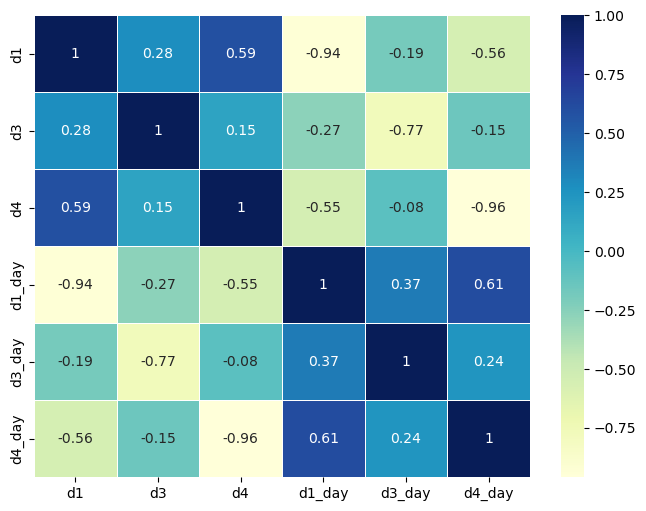

In [5]:
# I check the correlation of the created variables and the original ones
correlacion_c = ['d1', 'd3', 'd4', 'd1_day', 'd3_day', 'd4_day']
plt.figure(figsize=(8,6))
sns.heatmap(round(fraud_df[correlacion_c].corr('pearson'),2), cmap="YlGnBu", annot=True, linewidth=.5)
plt.show()

## 4. Valores missing

In [6]:
# I calculate the nulls by columns and the percentage
fraud_df_null_columns = fraud_df.isnull().sum().sort_values(ascending=False).to_frame('columns_null').reset_index()
fraud_df_null_columns['columns_percentage'] = fraud_df_null_columns['columns_null']/fraud_df.shape[0] * 100

fraud_df_null_columns

,index,columns_null,columns_percentage
0,m4,281353,47.709672
1,v6,278685,47.257253
2,v4,278685,47.257253
3,d11,278685,47.257253
4,v1,278685,47.257253
5,v3,278685,47.257253
6,v11,278685,47.257253
7,v8,278685,47.257253
8,m3,270513,45.871508
9,m1,270513,45.871508


In [7]:
fraud_df = fraud_df.dropna(subset=['v303'])
fraud_df = fraud_df.dropna(subset=['v320'])
fraud_df = fraud_df.dropna(subset=['v310'])
fraud_df = fraud_df.dropna(subset=['v309'])
fraud_df = fraud_df.dropna(subset=['v307'])
fraud_df = fraud_df.dropna(subset=['v305'])
fraud_df = fraud_df.dropna(subset=['v294'])
fraud_df = fraud_df.dropna(subset=['v297'])
fraud_df = fraud_df.dropna(subset=['v291'])
fraud_df = fraud_df.dropna(subset=['v286'])
fraud_df = fraud_df.dropna(subset=['v285'])
fraud_df = fraud_df.dropna(subset=['v284'])

En el EDA ya se eliminaron las columnas que tenían más de un 50% de valores nulos. No obstante, sigue habiendo variables con un elevado porcentaje. Estos nulos se van a imputar en el modelado, mediante un preprocesador que construiremos más adelantes. **En las variables categóricas se creará una nueva categoría y en las numéricas se imputará la mediana**.

Por otra parte, para dejar algo más limpio el dataset se han eliminado las filas con registros nulos de las variables que solo tenían 11 valores nulos.

## 5. Construcción del preprocesador

A continuación voy a crear varios Pipelines que se aplicarán en el preprocesador, para establecer el tratamiento que se va a dar a cada tipo de variable.

- One Hot Encoder: Variables categóricas con 5 o menos categorías.
- Target Encoder: Variables categóricas con más de 5 categorías.
- Ordinal Encoder: Variables binarias.
- Standard Scaler: Variables numéricas.

También, se van a imputar los valos nulos en los Pipelines. Las categóricas se van a rellenar con el valor mas frecuente; las binarias con -1 para que no afecte a las categorías existentes y las numéricas con -99 para que tampoco afecte al modelo.

In [8]:
var_ohe = ['productcd', 'card4', 'card6', 'm4']
var_bin =  ['m1', 'm2', 'm3', 'm6', 'v1', 'v14', 'v65', 'v88', 'v107']
var_te = ['card2', 'card3', 'card5', 'addr1', 'addr2', 'p_emaildomain', 'transaction_hour']

# I create a list for the numeric variables, selecting all those that are not in the previous two lists and excluding 
# the target variable.
all_columns = fraud_df.columns.tolist()
var_num = []
for column in all_columns:
    if column not in var_ohe and column not in var_te and column not in var_bin and column != 'isfraud':
        var_num.append(column)

In [9]:
# Make the pipeline to transform the categorical and numerical variables.
cat_transformer_ohe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

cat_transformer_bin = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
    ('onehot', OrdinalEncoder())])

cat_transformer_te = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoder())])

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-99)),
    ('scaler', StandardScaler())])

In [10]:
# I make the preprocessor, where I define the transformers and the list of variables to apply.
preprocessor = ColumnTransformer(
    transformers=[
        ('catohe', cat_transformer_ohe, var_ohe),
        ('catbin', cat_transformer_bin, var_bin),
        ('catte', cat_transformer_te, var_te),
        ('num', num_transformer, var_num)
    ]
)

In [11]:
# Save the preprocessor.
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)

## 6. División de los datos

In [12]:
# I split the dataset in train and test, selecting a size of the test of 20% and stratify because the data is unbalanced.
X_train, X_test, y_train, y_test = train_test_split(fraud_df.drop('isfraud',axis=1), 
                                                    fraud_df['isfraud'], 
                                                    stratify=fraud_df['isfraud'], 
                                                    test_size=0.2, random_state=12345
                                                   )

In [13]:
pd.concat([X_train, pd.DataFrame(y_train)]).describe()

,transactionamt,card2,card3,card5,addr1,addr2,c1,c3,c5,d1,d3,d4,d10,d11,d15,m1,m2,m3,m6,v1,v3,v4,v6,v8,v11,v13,v14,v17,v20,v23,v26,v27,v30,v36,v37,v40,v44,v47,v48,v54,v56,v62,v65,v67,v68,v70,v76,v78,v80,v83,v86,v88,v89,v91,v96,v98,v99,v104,v107,v108,v111,v115,v117,v120,v121,v123,v124,v127,v129,v130,v136,v281,v283,v284,v285,v286,v289,v291,v294,v297,v301,v303,v305,v307,v309,v310,v314,v320,transaction_day,transaction_hour,d1_day,d3_day,d4_day,isfraud
count,471766.000000,464644.000000,470532.000000,468383.000000,419518.000000,419518.000000,471766.000000,471766.000000,471766.000000,470792.000000,261786.000000,336557.000000,411020.000000,248875.000000,400590.000000,255406.000000,255406.000000,255406.000000,336627.000000,248875.000000,248875.000000,248875.000000,248875.000000,248875.000000,248875.000000,410986.000000,410986.000000,410986.000000,410986.000000,410986.000000,410986.000000,410986.000000,410986.000000,336520.000000,336520.000000,336520.000000,336520.000000,336520.000000,336520.000000,410155.000000,410155.000000,410155.000000,410155.000000,410155.000000,410155.000000,410155.000000,400554.000000,400554.000000,400554.000000,400554.000000,400554.000000,400554.000000,400554.000000,400554.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,471535.000000,470792.000000,470792.000000,471766.000000,471766.000000,471766.000000,470792.000000,471766.000000,471766.000000,471766.000000,470792.000000,471766.000000,471766.000000,471766.000000,471766.000000,471766.000000,470792.000000,471766.000000,471766.000000,471766.000000,470792.000000,261786.000000,336557.000000,471766.000000
mean,135.324768,362.631096,153.181301,199.307227,290.721468,86.804171,14.126372,0.005708,5.580169,94.498662,28.468337,140.150224,124.115588,146.559550,163.909449,0.999926,0.893969,0.788967,0.459702,0.999952,1.077870,0.846204,1.045649,1.027765,0.480056,0.599478,0.999501,0.132761,0.846245,1.034702,0.987379,0.000788,0.407367,0.579297,1.107260,0.174426,1.083959,1.038479,0.384161,0.620217,1.113557,0.863730,0.999664,0.997555,0.000561,0.408848,0.588016,1.138096,0.141916,0.878156,1.065002,0.999231,0.000934,0.421616,2.931297,0.061601,0.894506,0.084872,0.999576,1.004543,1.002515,1.032261,1.000356,1.000840,1.004248,1.030986,1.092511,329.359748,8.747384,92.164831,38.526726,0.084589,0.979951,0.087675,1.167348,0.031280,0.234237,1.662013,2.248057,0.088323,0.051738,0.279143,1.000008,401.683103,10.919477,118.174248,43.072442,41.759645,84.687665,13.865016,-9.899605,61.716410,-50.908019,0.034805
std,241.438345,157.720412,11.302561,41.249833,101.713016,2.665914,133.887695,0.158017,25.809382,157.719290,62.510321,191.126366,182.528474,185.981152,202.685127,0.008625,0.307878,0.408042,0.498374,0.006944,0.319637,0.439311,0.239054,0.185763,0.552861,0.531892,0.022328,0.360478,0.450855,0.248215,0.199208,0.028411,0.553903,0.538973,0.692092,0.489846,0.642113,0.230483,0.508546,0.533615,0.530480,0.467672,0.018340,0.242736,0.024384,0.555011,0.537833,0.708714,0.396481,0.455592,0.420733,0.027719,0.032598,0.562522,39.256747,0.283049,2.725759,0.641514,0.020590,0.080244,0.069246,0.189782,0.034827,0.041284,0.066901,0.227460,0.372740,4140.402531,120.397551,318.180550,453.155475,0.490707,1.479427,0.334816,3.297905,0.188424,0.593585,16.560596,38.845743,0.621982,0.314600,0.601063,0.002912,4303.365782,122.175269,355.179313,172.681075,481.748837,53.405955,7.606512,162.730264,81.914957,194.923004,0.183287
min,0.251000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-122.000000,0.000000,-53.000000,-74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [14]:
pd.concat([X_test, pd.DataFrame(y_test)]).describe()

,transactionamt,card2,card3,card5,addr1,addr2,c1,c3,c5,d1,d3,d4,d10,d11,d15,m1,m2,m3,m6,v1,v3,v4,v6,v8,v11,v13,v14,v17,v20,v23,v26,v27,v30,v36,v37,v40,v44,v47,v48,v54,v56,v62,v65,v67,v68,v70,v76,v78,v80,v83,v86,v88,v89,v91,v96,v98,v99,v104,v107,v108,v111,v115,v117,v120,v121,v123,v124,v127,v129,v130,v136,v281,v283,v284,v285,v286,v289,v291,v294,v297,v301,v303,v305,v307,v309,v310,v314,v320,transaction_day,transaction_hour,d1_day,d3_day,d4_day,isfraud
count,117942.000000,116144.000000,117613.000000,117084.000000,104874.000000,104874.000000,117942.000000,117942.000000,117942.000000,117708.000000,65209.000000,84380.000000,102752.000000,62157.000000,100104.000000,63798.000000,63798.000000,63798.000000,84239.000000,62157.000000,62157.000000,62157.000000,62157.000000,62157.000000,62157.000000,102735.000000,102735.000000,102735.000000,102735.000000,102735.000000,102735.000000,102735.000000,102735.000000,84370.000000,84370.000000,84370.000000,84370.000000,84370.000000,84370.000000,102544.000000,102544.000000,102544.000000,102544.000000,102544.000000,102544.000000,102544.000000,100089.000000,100089.000000,100089.000000,100089.000000,100089.000000,100089.000000,100089.000000,100089.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117887.000000,117708.000000,117708.000000,117942.000000,117942.000000,117942.000000,117708.000000,117942.000000,117942.000000,117942.000000,117708.000000,117942.000000,117942.0,117942.000000,117942.000000,117942.000000,117708.000000,117942.000000,117942.000000,117942.000000,117708.000000,65209.000000,84380.000000,117942.000000
mean,134.221154,362.388191,153.166920,199.274051,290.734596,86.804642,13.782402,0.005333,5.572112,94.165036,28.092518,139.927471,123.896129,146.848754,163.862513,0.999906,0.892567,0.784789,0.456712,0.999920,1.076323,0.846437,1.044758,1.027511,0.476262,0.599095,0.999494,0.134112,0.846440,1.034574,0.987434,0.000730,0.404954,0.580586,1.102264,0.174825,1.082565,1.037727,0.382257,0.619120,1.114117,0.866574,0.999659,0.997543,0.000429,0.407084,0.587018,1.135939,0.142283,0.881975,1.062155,0.999301,0.000779,0.418797,3.296606,0.062025,0.894017,0.087491,0.999593,1.004827,1.002672,1.032845,1.000492,1.000942,1.004284,1.031615,1.094735,365.456757,8.714401,91.774320,40.104293,0.085160,0.982015,0.088162,1.162707,0.031041,0.234317,1.582066,2.502145,0.091223,0.050532,0.282444,1.0,432.054164,11.004283,117.842596,43.390730,43.332408,84.754439,13.855463,-9.497315,62.213253,-50.790365,0.034805
std,230.409936,158.075454,11.337364,41.162256,101.831904,2.673199,131.050312,0.116169,25.777121,157.708277,62.103569,191.063370,183.117480,186.343351,203.142230,0.009697,0.309665,0.410972,0.498126,0.008969,0.317759,0.439082,0.238767,0.187491,0.550936,0.532116,0.022492,0.362960,0.449088,0.241853,0.200812,0.029424,0.552055,0.539128,0.655825,0.489859,0.626025,0.234840,0.507606,0.534732,0.552718,0.468511,0.018472,0.244407,0.021176,0.553354,0.537912,0.717949,0.397528,0.456338,0.400003,0.026437,0.029303,0.560113,44.069614,0.281634,2.701387,0.676869,0.020174,0.084224,0.076181,0.191493,0.036140,0.042296,0.066978,0.230939,0.379433,4623.446165,82.344343,304.421316,447.873512,0.498431,1.506128,0.334840,3.221940,0.190082,0.590867,14.099566,41.947548,0.652457,0.312753,0.608660,0.0,4729.085996,88.308985,344.265590,175.562590,440.509108,53.508287,7.603925,162.672797,81.880630,195.007304,0.183287
min,0.292000,100.000000,100.000000,100.000000,100.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-83.000000,0.000000,0.000000,-83.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

## 7. Feature selection

En este apartado se va a llevar a cabo la selección de variables. Se van a emplear distintos modelos (Recursive Feature Elimination, Boruta y Lasso), con el fin de comparar sus selecciones en el modelado. El objetivo es que permita disminuir el número de variables necesarias para entrenar y no disminuya la precisión de los modelos.

En primer lugar, voy a aplicar el preprocesador a los conjuntos de train y test para obtenerlos transformados. Esto facilitará la selección de variables, ya que podremos filtrar el dataset directamente con las variables que los modelos consideren más importantes.

### 7.1. Obtención del dataset transformado

In [15]:
# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train, y_train)

# Transform the testing data
X_test_transformed = preprocessor.transform(X_test)

In [16]:
# Get the transformed column names for one-hot encoded columns
ohe_columns = preprocessor.named_transformers_['catohe'].named_steps['onehot'].get_feature_names_out(var_ohe)

# Concatenate all the column names
column_names = np.concatenate((ohe_columns, var_bin, var_te, var_num))

# Convert the transformed numpy arrays to pandas dataframes
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=column_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=column_names)

In [17]:
# Original column order
original_columns = ['transactionamt', 'productcd', 'card2', 'card3', 'card4', 'card5',
       'card6', 'addr1', 'addr2', 'p_emaildomain', 'c1', 'c3', 'c5', 'd1',
       'd3', 'd4', 'd10', 'd11', 'd15', 'm1', 'm2', 'm3', 'm4', 'm6', 'v1',
       'v3', 'v4', 'v6', 'v8', 'v11', 'v13', 'v14', 'v17', 'v20', 'v23', 'v26',
       'v27', 'v30', 'v36', 'v37', 'v40', 'v44', 'v47', 'v48', 'v54', 'v56',
       'v62', 'v65', 'v67', 'v68', 'v70', 'v76', 'v78', 'v80', 'v83', 'v86',
       'v88', 'v89', 'v91', 'v96', 'v98', 'v99', 'v104', 'v107', 'v108',
       'v111', 'v115', 'v117', 'v120', 'v121', 'v123', 'v124', 'v127', 'v129',
       'v130', 'v136', 'v281', 'v283', 'v284', 'v285', 'v286', 'v289', 'v291',
       'v294', 'v297', 'v301', 'v303', 'v305', 'v307', 'v309', 'v310', 'v314',
       'v320', 'transaction_day', 'transaction_hour', 'd1_day',
       'd3_day', 'd4_day']

def find_transformed_columns(original_col, transformed_columns):
    # Check if the original column is present in the transformed_columns
    if original_col in transformed_columns:
        return [original_col]
    else:
        # Find transformed columns corresponding to the original column
        transformed_cols = [col for col in transformed_columns if col.startswith(f"{original_col}_")]
        if transformed_cols:
            return transformed_cols
        else:
            return []

# Create a list of original feature columns (excluding the target variable)
original_feature_columns = [col for col in original_columns if col != 'isfraud']

# Create a dictionary to map original columns to transformed columns
column_mapping = {original_col: find_transformed_columns(original_col, X_train_transformed_df.columns) for original_col in original_feature_columns}

# Flatten the dictionary to a list of transformed columns in the original order
ordered_columns = [item for sublist in column_mapping.values() for item in sublist]

# Reorder the transformed dataset to match the original order
X_train_transformed_df = X_train_transformed_df[ordered_columns]
X_test_transformed_df = X_test_transformed_df[ordered_columns]

### 7.2. Aplicación de modelos de selección de variables

#### Boruta

In [18]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=12345)  # Modifica los hiperparámetros según tus necesidades

sel_ridge = BorutaPy(rf, verbose=2, random_state=1, n_estimators='auto')

sel_ridge.fit(X_train_transformed_df.values, y_train.values)  # Asegúrate de que X_train_transformed_df y y_train sean arreglos numpy

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	113
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	98
Tentative: 	6
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	98
Tentative: 	6
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	98
Tentative: 	6
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	98
Tentative: 	6
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	98
Tentative: 	6
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	98
Tentative: 	6
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	98
Tentative: 	6
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	98
Tentative: 	6
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	98
Tentative: 	6
Rejecte

BorutaPy(estimator=RandomForestClassifier(max_depth=5, n_estimators=284,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1ADCB392440),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x1ADCB392440, verbose=2)

In [19]:
sel_boruta = X_train_transformed_df.columns[sel_ridge.support_]

X_train_boruta = X_train_transformed_df[sel_boruta]
X_test_boruta = X_test_transformed_df[sel_boruta]

total features: 113
selected features: 100
Index(['transactionamt', 'productcd_C', 'productcd_H', 'productcd_R',
       'productcd_S', 'productcd_W', 'card2', 'card3', 'card4_discover',
       'card5', 'card6_credit', 'card6_debit', 'addr1', 'addr2',
       'p_emaildomain', 'c1', 'c5', 'd1', 'd3', 'd4', 'd10', 'd11', 'd15',
       'm1', 'm2', 'm3', 'm4_M0', 'm4_M2', 'm4_None', 'm6', 'v1', 'v3', 'v4',
       'v6', 'v8', 'v11', 'v13', 'v14', 'v17', 'v20', 'v23', 'v26', 'v27',
       'v30', 'v36', 'v37', 'v40', 'v44', 'v47', 'v48', 'v54', 'v56', 'v62',
       'v65', 'v67', 'v68', 'v70', 'v76', 'v78', 'v80', 'v83', 'v86', 'v88',
       'v89', 'v91', 'v96', 'v98', 'v99', 'v104', 'v108', 'v111', 'v115',
       'v117', 'v123', 'v124', 'v127', 'v129', 'v130', 'v136', 'v281', 'v283',
       'v284', 'v285', 'v286', 'v289', 'v291', 'v294', 'v297', 'v301', 'v303',
       'v307', 'v309', 'v310', 'v314', 'v320', 'transaction_day',
       'transaction_hour', 'd1_day', 'd3_day', 'd4_day'],
      dtype

#### Recursive Feature Elimination (RFE)

In [21]:
model = DecisionTreeClassifier()

# model = RandomForestClassifier()
rfe = RFE(model, verbose=1) #verbose=1 para ver iterativamente que pasa,
# n_features_to_select: por defecto se selecciona la mitad si no pones este parámetro , n_features_to_select=30
fit = rfe.fit(X_train_transformed_df, y_train)


print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Fitting estimator with 113 features.
Fitting estimator with 112 features.
Fitting estimator with 111 features.
Fitting estimator with 110 features.
Fitting estimator with 109 features.
Fitting estimator with 108 features.
Fitting estimator with 107 features.
Fitting estimator with 106 features.
Fitting estimator with 105 features.
Fitting estimator with 104 features.
Fitting estimator with 103 features.
Fitting estimator with 102 features.
Fitting estimator with 101 features.
Fitting estimator with 100 features.
Fitting estimator with 99 features.
Fitting estimator with 98 features.
Fitting estimator with 97 features.
Fitting estimator with 96 features.
Fitting estimator with 95 features.
Fitting estimator with 94 features.
Fitting estimator with 93 features.
Fitting estimator with 92 features.
Fitting estimator with 91 features.
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estima

In [22]:
sel_rfe = X_train_transformed_df.columns[fit.support_].to_list()

X_train_rfe = X_train_transformed_df[sel_rfe]
X_test_rfe = X_test_transformed_df[sel_rfe]

#### Lasso

###### Prueba 1

In [24]:
sel_lasso = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='liblinear'), threshold = 0.05) 
sel_lasso.fit(X_train_transformed_df, y_train)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'),
                threshold=0.05)

In [25]:
self_lasso = X_train_transformed_df.columns[sel_lasso.get_support()]

X_train_lasso1 = X_train_transformed_df[self_lasso]
X_test_lasso1 = X_test_transformed_df[self_lasso]

###### Prueba 2

In [26]:
sel_lasso2 = SelectFromModel(LogisticRegression(C=1, penalty='l1', 
                                          solver='liblinear'), threshold = 0.25) 
sel_lasso2.fit(X_train_transformed_df, y_train)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'),
                threshold=0.25)

In [27]:
self_lasso2 = X_train_transformed_df.columns[sel_lasso2.get_support()]

X_train_lasso2 = X_train_transformed_df[self_lasso2]
X_test_lasso2 = X_test_transformed_df[self_lasso2]

## 8. Exportación de los datos

In [28]:
# Save train and test set
X_train.to_parquet("../data/processed/X_train.parquet")
X_test.to_parquet("../data/processed/X_test.parquet")
pd.DataFrame(y_train).to_parquet("../data/processed/y_train.parquet")
pd.DataFrame(y_test).to_parquet("../data/processed/y_test.parquet")

In [29]:
#save train and test with boruta applied
X_train_boruta.to_parquet("../data/processed/X_train_boruta.parquet")
X_test_boruta.to_parquet("../data/processed/X_test_boruta.parquet")

In [30]:
#save train and test with RFE applied
X_train_rfe.to_parquet("../data/processed/X_train_rfe.parquet")
X_test_rfe.to_parquet("../data/processed/X_test_rfe.parquet")

In [32]:
#save train and test with lasso applied
X_train_lasso1.to_parquet("../data/processed/X_train_lasso1.parquet")
X_test_lasso1.to_parquet("../data/processed/X_test_lasso1.parquet")

In [33]:
#save train and test with lasso applied
X_train_lasso2.to_parquet("../data/processed/X_train_lasso2.parquet")
X_test_lasso2.to_parquet("../data/processed/X_test_lasso2.parquet")